In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            
    except RuntimeError as e:
        print(e)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
from time import time
import json
from glob import glob
from PIL import Image
import pickle
from functools import lru_cache
import os

# the compute_blue implementation is taken from:
# https://github.com/tensorflow/models/blob/master/official/nlp/transformer/compute_bleu.py
from helpers.evaluation import compute_bleu
from helpers.files import load_config

In [2]:
config = load_config('config.json')

# Download Data

In [3]:
# Download caption annotation files
dataset_config = config['dataset']
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('./datasets') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = dataset_config['annotation_url'],
                                          extract = True)
    os.remove(annotation_zip)
    annotation_file = os.path.dirname(annotation_folder) + '/annotations/captions_train2014.json'
else:
    annotation_file = './datasets/annotations/captions_train2014.json'

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('./datasets') + image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('./datasets'),
                                      origin = dataset_config['images_url'],
                                      extract = True)
    PATH = os.path.dirname(image_zip) + image_folder
    os.remove(image_zip)
else:
    PATH = os.path.abspath('./datasets') + image_folder

# Load Dataset

In [4]:
with open(annotation_file, 'r') as f:
        annotations = json.load(f)

def load_dataset(annotations, shuffle=True, 
                 test_size=0.2, num_examples=None):

    # variables to store the images url and their corresponding captions.
    all_captions = []
    all_img_id_vector = []

    # for each annotation add sos and eos tokens and map 
    for annotation in annotations['annotations']:
        caption = '<sos> ' + annotation['caption'] + ' <eos>'
        image_id = annotation['image_id']
        all_img_id_vector.append(image_id)
        all_captions.append(caption)
    
    train_imgs, test_imgs, train_captions, test_captions = train_test_split(all_img_id_vector[:num_examples],
                                                                            all_captions[:num_examples], 
                                                                            test_size=test_size, shuffle=shuffle)
    
    return train_imgs, test_imgs, train_captions, test_captions

In [38]:
num_examples = dataset_config['num_examples']
X_train, X_test, y_train, y_test = load_dataset(annotations, num_examples=num_examples)

In [6]:
@lru_cache(maxsize=256)
def get_all_captions_by_image_id(image_id):
    captions = []
    for caption in annotations['annotations']:
        if caption['image_id'] == image_id:
            captions.append(caption['caption'])
    return captions

In [7]:
captions = get_all_captions_by_image_id(X_train[0])
captions

['A man holds a banana as if it were a telephone receiver.',
 'Man pretending to talk into a banana as though it were a telephone.',
 'A man holding a banana to his ear like a telephone.',
 'A man holding a banana to his ear like a phone.',
 'a man holding a banana as if it were a phone']

# Preprocessing

## Encoder Preprocessing

We are going to use inceptionV3 model and hence its processing

1. We will load the image from the ID.
2. Resize the image to 299x299
3. Preprocess using InceptionV3 preprocess function

In [8]:
def preprocess_image(image_id):
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Decoder Preprocessing

As usual, we need to:

1. Split, clean and tokenize the texts to build the vocabulary.
2. Constrain number of words to most common words and add the rest of words to Out-of-Vocabulary bucket.
3. Convert the texts to sequences.
4. Pad the texts to maximum

In [39]:
top_k = 6000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<UNK>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(y_train)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

y_train = tokenizer.texts_to_sequences(y_train)
y_test = tokenizer.texts_to_sequences(y_test)

y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train, padding="post")
max_length = y_train.shape[-1]

y_test = tf.keras.preprocessing.sequence.pad_sequences(y_test, padding="post", maxlen=max_length)

# Create Dataset

In [40]:
def preprocess(img_id, cap):
    img_tensor, _ = preprocess_image(img_id)
    return img_tensor, cap

In [41]:
batch_size = dataset_config['batch_size']
buffer_size = 1000

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          preprocess, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True).prefetch(1)

# Build Model

In [42]:
model_config = config['model']
epochs = model_config['epochs']
embedding_dim = model_config['embedding_dim']
units = model_config['units']
attention = model_config['attention']

train_size = len(X_train)
steps_per_epoch = train_size // batch_size
vocab_size = len(tokenizer.word_index) + 1

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [43]:
from model import CNNEncoder, RNNDecoder

encoder = CNNEncoder(units)
decoder = RNNDecoder(vocab_size, embedding_dim, units, attention=attention)

In [44]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
train_loss = tf.keras.metrics.Mean(name='train_loss')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

# Training

In [45]:
@tf.function
def predict(enc_input, dec_input, hidden, dec_true, training=True):
    loss = 0
    enc_output = encoder(enc_input)
    
    for i in range(1, dec_true.shape[1]):
        
        dec_output, hidden, _ = decoder(dec_input, hidden, enc_output)
        
        loss += loss_function(dec_true[:, i], dec_output)
        
        if training:
            dec_input = tf.expand_dims(dec_true[:, i], 1)
        else:
            predicted_id = tf.argmax(dec_output[0])
            dec_input = tf.expand_dims([predicted_id], 0)
    return loss

In [46]:
@tf.function
def train_step(img_tensor, target):
    
    hidden = decoder.reset_state(target.shape[0])
    
    dec_input = tf.expand_dims([tokenizer.word_index['<sos>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        loss = predict(img_tensor, dec_input, hidden, target, training=True)
    
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss

In [47]:
@tf.function
def val_loss_per_batch(img_tensor, target):
    
    hidden = decoder.reset_state(target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<sos>']] * target.shape[0], 1)
    
    # compute the loss
    loss = predict(img_tensor, dec_input, hidden, target, training=False)
    
    # take the mean of the loss over the timestep
    loss = loss / int(max_length)
    
    # take the mean of the loss over the whole samples
    return loss

In [48]:
from helpers.logging import print_status_bar

for epoch in range(epochs):
    start = time()
    
    for (step, (img, cap)) in enumerate(dataset):
        loss = train_step(img, cap)
        train_loss(loss)
        print_status_bar(step * batch_size, train_size, train_loss, None)
    
    # Validate the X_valid
#     for (batch, (val_img, val_cap)) in enumerate(val_dataset):
#         print(batch)
#         val_losses = val_loss_per_batch(val_img, val_cap)
#     val_losses /= num_steps
#     val_plot.append(val_losses)

    print_status_bar(train_size, train_size, train_loss, None)
    print ('Time taken for 1 epoch {} sec\n'.format(time() - start))

800/800 [==============================] - train_loss: 59.4259
Time taken for 1 epoch 205.54862332344055 sec

800/800 [==============================] - train_loss: 56.4853
Time taken for 1 epoch 171.05079627037048 sec



KeyboardInterrupt: 

# Evaluation

The evaluation function consists of the following:

- Similar to step function, except we don't do teacher forcing.
- Stop predicting when the model predicts the end token.
- Store the attention weights for every time step

In [67]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))  #
    
    hidden = decoder.reset_state(batch_size=1)
    image, _ = preprocess_image(image)
    image = tf.expand_dims(image, 0)
    features = encoder(image)
    
    dec_input = tf.expand_dims([tokenizer.word_index['<sos>']], 0)
    result = []
    
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, hidden, features)
        
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        
        if tokenizer.index_word[predicted_id] == '<eos>':
            return result, attention_plot
        
        result.append(tokenizer.index_word[predicted_id])
        
        dec_input = tf.expand_dims([predicted_id], 0)
        
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [75]:
def plot_attention(image_id, result, attention_plot):
    image = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(50, 50))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2+1, len_result//2 +1, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [76]:
def caption(image_id, tokenizer, verbose=True):    
    real_captions = get_all_captions_by_image_id(image_id)
    result, attention_plot = evaluate(image_id)
    pred_caption = ' '.join(result)        
    
    prediction = [tokenizer.texts_to_sequences([pred_caption])[0]]
    references = [tokenizer.texts_to_sequences(real_captions)]
    bleu = compute_bleu(references, prediction, max_order=3)
    
    if verbose:
        print ('Real Caption:', real_captions)
        print ('Prediction Caption:', pred_caption)
        print("bleu result:", bleu)
        plot_attention(image_id, result, attention_plot)
    
    return bleu

def caption_by_index(image_index, tokenizer, verbose=True):
    image_id = X_test[image_index]
    if verbose:
        print("processing image id:", image_id, "that have index of:", image_index)
    caption(image_id, tokenizer, verbose)

processing image id: 230843 that have index of: 91
Real Caption: ['A young boy surfing  in low waves.', 'A young boy is standing on a surfboard and riding a wave.', 'A surfer rides his surf board on some very small waves.', 'A young boy is standing on a surfboard in the water.', 'A young boy is standing on a surfboard in the ocean. ']
Prediction Caption: stone countertops flower been pot closed children surfers phone ceramic cars base holding remodeled 
 holder women hang hallway handsome elegant brass
bleu result: (0.0, [0.0, 0.0, 0.0], 1.0, 10000003.142857144, 22, 7)


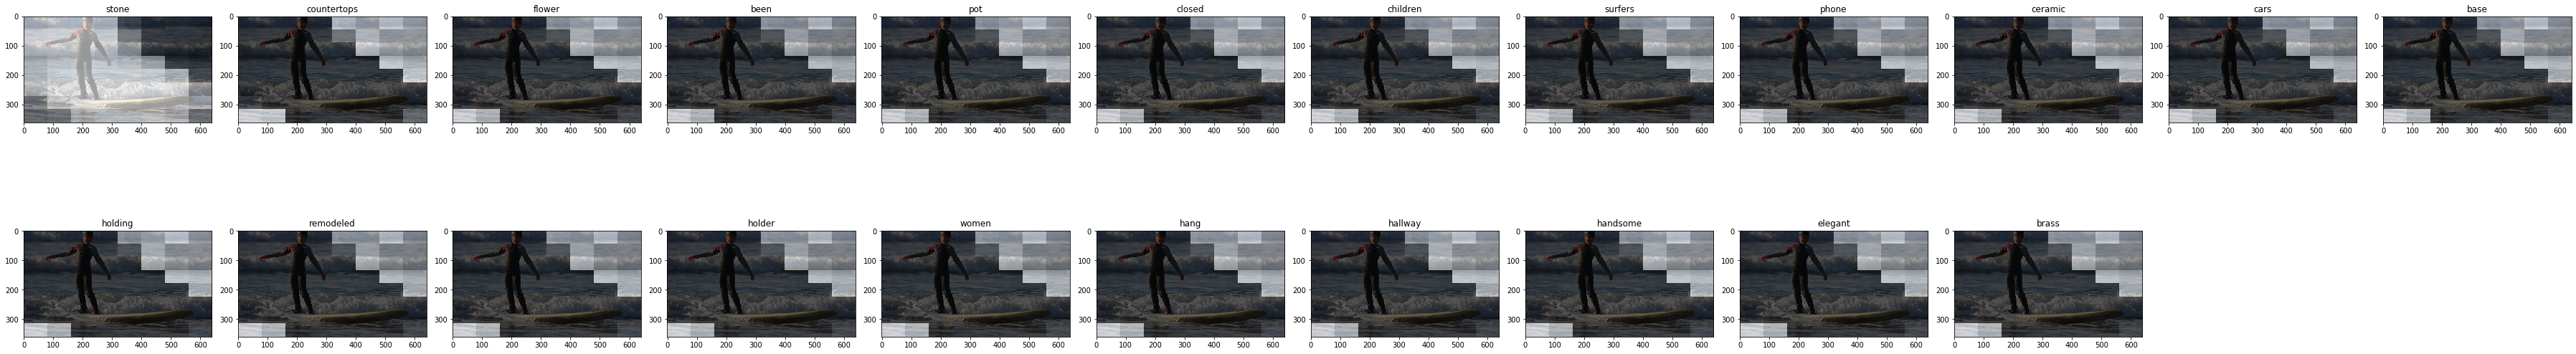

In [77]:
caption_by_index(np.random.randint(0, 200), tokenizer)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_img_name_vector)

bleu1, bleu2, bleu3, bleu = [], [], [], []
for img in test_dataset:
    all_bleu = caption(img.numpy(), tokenizer, verbose=False)
    bleu.append(all_bleu[0])
    bleu1.append(all_bleu[1][0])
    bleu2.append(all_bleu[1][1])
    bleu3.append(all_bleu[1][2])

print("bleu: {}\tbleu1: {}\tbleu2: {}\tbleu 3: {}".format(np.mean(bleu), np.mean(bleu1), np.mean(bleu2), np.mean(bleu3)))

## Notes to improve the model:

- Add validation set and exit trying earlier.
- Transfer learning of a better embedding layer.